In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.activations import relu
from spektral.layers import GraphSageConv
from spektral.data.graph import Graph
from contextlib import suppress
import spektral
import numpy as np
from spektral.data.graph import Graph

In [24]:
class GNN(tf.keras.Model):
    def __init__(self, hidden_channels, out_channels, add_linear=True):
        super(GNN, self).__init__()
        self.conv1 = GraphSageConv(hidden_channels)
        self.bn1 = BatchNormalization()
        self.conv2 = GraphSageConv(hidden_channels)
        self.bn2 = BatchNormalization()
        self.conv3 = GraphSageConv(out_channels)
        self.bn3 = BatchNormalization()
        
        if add_linear:
            self.lin = Dense(out_channels)
        else:
            self.lin = None
    
    def call(self, inputs):
        x, adj = inputs
        
        x1 = self.bn1(relu(self.conv1(inputs)))
        x2 = self.bn2(relu(self.conv2([x1, adj])))
        x3 = self.bn3(relu(self.conv3([x2, adj])))

        x = tf.concat([x1, x2, x3], axis=-1)

        if self.lin is not None:
            x = relu(self.lin(x))

        return x

In [25]:
def dense_diff_pool(x, adj, s):
    # https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/dense/diff_pool.html#dense_diff_pool
    # add batch dimension if necessary
    with suppress(TypeError):
        adj = tf.sparse.to_dense(adj)
        s = tf.sparse.to_dense(adj)

    #x = tf.expand_dims(x, axis=0) if len(x.shape) == 2 else x
    #adj = tf.expand_dims(adj, axis=0) if len(adj.shape) == 2 else adj
    #s = tf.expand_dims(s, axis=0) if len(s.shape) == 2 else s

    #batch_size, num_nodes, _ = x.shape  # used when maks is implemented

    # s = tf.nn.softmax(s, axis=-1)
    s = tf.nn.softmax(s, axis=-1)    # check if this works as tf.nn.softmax(x, axis=-1)
    st = tf.transpose(s, (1, 0))

    out = tf.matmul(st, x)
    out_adj = tf.matmul(tf.matmul(st, adj), s)

    link_loss = adj - tf.matmul(s, st)
    link_loss = tf.norm(link_loss, ord=2)
    link_loss = link_loss / tf.size(adj, out_type=tf.dtypes.float32)

    ent_loss = tf.reduce_mean(tf.reduce_sum(-s * tf.math.log(s + 1e-15), axis=-1))

    return out, tf.sparse.from_dense(out_adj), link_loss, ent_loss

In [26]:
class Net(tf.keras.Model):
    def __init__(self, num_classes=6, max_nodes=200):
        super(Net, self).__init__()

        num_nodes = np.ceil(0.5 * max_nodes).astype(int)
        self.gnn1_pool = GNN(64, num_nodes)
        self.gnn1_embed = GNN(64, 64, add_linear=False)

        num_nodes = np.ceil(0.5 * num_nodes).astype(int)
        self.gnn2_pool = GNN(64, num_nodes)
        self.gnn2_embed = GNN(64, 64, add_linear=False)

        self.gnn3_embed = GNN(64, 64, add_linear=False)

        self.lin1 = Dense(64)
        self.lin2 = Dense(num_classes)
    
    def call(self, inputs):
        x, adj = inputs
        s = self.gnn1_pool(inputs)
        x = self.gnn1_embed([x, adj])

        x, adj, l1, e1 = dense_diff_pool(x, adj, s)

        s = self.gnn2_pool([x, adj])
        x = self.gnn2_embed([x, adj])

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        x = self.gnn3_embed([x, adj])

        x = tf.reduce_mean(x, axis=1)

        if len(x.shape) == 1:
            x = tf.expand_dims(x, axis=0)

        x = relu(self.lin1(x))
        x = self.lin2(x)

        return tf.nn.log_softmax(x, axis=-1), l1 + l2, e1 + e2

In [27]:
num_nodes = 200
num_features = 10

x = tf.Variable(tf.random.normal((num_nodes, num_features)))
adj = tf.sparse.from_dense(tf.round(tf.random.uniform((num_nodes, num_nodes))))
net = Net()
net([x, adj])[0]

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[-1.7318863, -1.7922283, -1.8050377, -1.7345929, -1.8862858,
        -1.8085786]], dtype=float32)>

In [75]:
root = 40095521


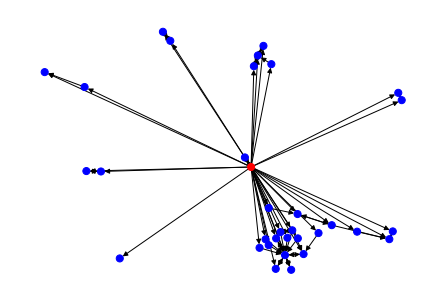

In [80]:
G = nx.from_edgelist(load_edge_list("./dataset/WICO/5G_Conspiracy_Graphs/1/edges.txt"), create_using=nx.DiGraph)
G.add_edges_from(new_edges)
#nx.draw_spring(G, node_size=50, node_color=colors)

In [60]:
pd.read_csv("./dataset/WICO/5G_Conspiracy_Graphs/1/nodes.csv").sort_values("time")

,id,time,friends,followers
39,40095521,0,12,10
28,233878867,302686,7,2
57,133999060,311964,10,12
30,123158829,312784,13,14
10,105141051,313648,11,11
...,...,...,...,...
21,299260908,518563,9,7
65,164877190,544305,11,10
54,104852114,547208,9,9
88,128913810,554961,5,9
